Preliminaries

In [1]:
# Processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Prediction
import sklearn.ensemble as sklearn_ensemble
import sklearn.linear_model as sklearn_linear_model
import statsmodels.api as sm

# Sim
from tqdm import tqdm

# Plot
sns.set(font_scale=5)
DIST_CAT_PLOT_PARAMS_D = {"height": 14, "aspect": .8}

In [2]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

In [3]:
def generate_lunceford(n=1000, miss_propensity=False, miss_outcome=False):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)
    
    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)
    
    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    
    #     Proensity model
    if not miss_propensity:
        e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    else:
        e = np.power(1 + np.exp((- BETA[0] - x.dot(BETA[1:])) - (3*x[:,1])), -1)
        
    # Assignment mechanism
    a = np.random.binomial(1, e, n)
    
    #     Outcome model misspecification
    if not miss_outcome:
        y = x.dot(NU[1:-1]) + v.dot(XI) + NU[-1]*a + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)
    else:
        y = x.dot(np.array([-0.1, 0.1, -0.1])) + 2*a + v.dot(np.array([-1, 1, 1])) + 4*np.log(1 + np.multiply(x[:, 0], x[:, 0])) + 5*np.maximum(x[:, 0], x[:, 1]) + np.random.normal(0, 1, n)
    
    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1), np.expand_dims(e, axis=1)], axis=1), columns=["X1", "X2", "X3", "A", "V1", "V2", "V3", "Y", "e"])
    synthetic_data_df["A"] = synthetic_data_df["A"].astype(int)
    
    return synthetic_data_df

In [4]:
def generate_wager_nie(n=1000, p=5, all_variables=False):
    X = np.random.uniform(0, 1, n*p).reshape(n, p)
    b = np.maximum(X[:, 0], X[:, 1]) + 5 * X[:, 2]
    e = np.power(1 + np.exp(- (np.multiply(X[:, 0], (X[:, 2])) + X[:, 1])), -1)
    tau = 2
    
    # complete potential outcomes, treatment, and observed outcome
    synthetic_data_df = pd.DataFrame({"b": b, "tau": [tau]*len(e), "e": e})
    synthetic_data_df["mu_0"] = synthetic_data_df["b"] - 0.5*synthetic_data_df["tau"]
    synthetic_data_df["mu_1"] = synthetic_data_df["b"] + 0.5*synthetic_data_df["tau"]
    synthetic_data_df["Y_0"] = synthetic_data_df["mu_0"] + np.random.normal(0, 0.1, n)
    synthetic_data_df["Y_1"] = synthetic_data_df["mu_1"] + np.random.normal(0, 0.1, n)
    synthetic_data_df["A"] = np.random.binomial(1, e, n)
    synthetic_data_df["Y"] = np.multiply(synthetic_data_df["A"], synthetic_data_df["Y_1"]) + np.multiply(1-synthetic_data_df["A"], synthetic_data_df["Y_0"])
    
    #     Add X
    X_df = pd.DataFrame(X, columns=["X{}".format(i+1) for i in range(p)])
    synthetic_data_df = pd.concat([X_df, synthetic_data_df], axis=1)
    
    if all_variables:
        return synthetic_data_df
    else:
        return synthetic_data_df[["X{}".format(i+1) for i in range(p)] + ["Y", "A"]]

## Refresher from Lab 2

A useful function

In [5]:
def get_outcomes(data_df):
        treated_idx = data_df["A"] == 1
        control_idx = data_df["A"] == 0

        y1 = data_df.loc[treated_idx, "Y"]
        y0 = data_df.loc[control_idx, "Y"]

        return y0, y1

Basic estimators

In [6]:
def difference_in_means(data_df):
        y0, y1 = get_outcomes(data_df)
        tau_hat = y1.mean() - y0.mean()
        return tau_hat

def g_formula(df, covariate_variable_l, is_parametric=True):
        # Select dataframe
        df0 = df[df["A"] == 0]
        df1 = df[df["A"] == 1]

        if is_parametric:
            # Control
            control_ols = sm.OLS(df0["Y"], sm.add_constant(df0[covariate_variable_l], has_constant='add'))
            control_reg = control_ols.fit()
            mu0_hat = control_reg.predict(sm.add_constant(df[covariate_variable_l], has_constant='add'))

            # Treatment
            treatment_ols = sm.OLS(df1["Y"], sm.add_constant(df1[covariate_variable_l], has_constant='add'))
            treatment_reg = treatment_ols.fit()
            mu1_hat = treatment_reg.predict(sm.add_constant(df[covariate_variable_l], has_constant='add'))
        else:
            # Control
            control_reg = sklearn_ensemble.RandomForestRegressor(n_estimators = 100, random_state = 0)
            control_reg.fit(df0[covariate_variable_l], df0["Y"]) 
            mu0_hat = control_reg.predict(df[covariate_variable_l])

            # Treatment
            treatment_reg = sklearn_ensemble.RandomForestRegressor(n_estimators = 100, random_state = 0)
            treatment_reg.fit(df1[covariate_variable_l], df1["Y"]) 
            mu1_hat = treatment_reg.predict(df[covariate_variable_l])

        return (np.array(mu1_hat) - np.array(mu0_hat)).mean()

The IPW estimator

In [15]:
def clip_probabilities_(prob, th=0.1) :
  prob[prob < th] = th
  prob[prob > (1-th)] = 1-th
  return prob 

   
def estimate_ipw_weights(df, covariate_variable_l, is_parametric, clip_probabilities=False):
  if is_parametric:
    # estimate propensity scores without and with extended set
    propensity_model = sklearn_linear_model.LogisticRegression(random_state=0, fit_intercept=True).fit(df[covariate_variable_l], df["A"])
  else:
    propensity_model = sklearn_ensemble.RandomForestClassifier(n_estimators = 100, random_state = 0, min_samples_leaf=1).fit(df[covariate_variable_l], df["A"])
  estimates_prob = propensity_model.predict_proba(df[covariate_variable_l])[:, 1]
  if clip_probabilities:
    estimates_prob = clip_probabilities_(estimates_prob)
  return estimates_prob
        
    
def estimate_ipw(df, covariate_variable_l, is_parametric=True, clip_probabilities=False):
  # compute estimates
  Y = df["Y"].to_numpy()
  A = df["A"].to_numpy()
  e_hat = estimate_ipw_weights(df, covariate_variable_l, is_parametric=is_parametric, clip_probabilities=clip_probabilities)
  return (Y * ((A/e_hat) - (1-A)/(1-e_hat))).mean()

Question 0

In [16]:
def outcome_model_single_cross_fit(df_d, covariate_variable_l, is_parametric=True):
        if is_parametric:
            # Control
            control_ols = sm.OLS(df_d["df0_fit"]["Y"], sm.add_constant(df_d["df0_fit"][covariate_variable_l], has_constant='add'))
            control_reg = control_ols.fit()
            mu0_hat = control_reg.predict(sm.add_constant(df_d["df_predict"][covariate_variable_l], has_constant='add'))

            # Treatment
            treatment_ols = sm.OLS(df_d["df1_fit"]["Y"], sm.add_constant(df_d["df1_fit"][covariate_variable_l], has_constant='add'))
            treatment_reg = treatment_ols.fit()
            mu1_hat = treatment_reg.predict(sm.add_constant(df_d["df_predict"][covariate_variable_l], has_constant='add'))
        else:
            # Control
            control_reg = sklearn_ensemble.RandomForestRegressor(n_estimators = 100, random_state = 0)
            control_reg.fit(df_d["df0_fit"][covariate_variable_l], df_d["df0_fit"]["Y"]) 
            mu0_hat = control_reg.predict(df_d["df_predict"][covariate_variable_l])

            # Treatment
            treatment_reg = sklearn_ensemble.RandomForestRegressor(n_estimators = 100, random_state = 0)
            treatment_reg.fit(df_d["df1_fit"][covariate_variable_l], df_d["df1_fit"]["Y"]) 
            mu1_hat = treatment_reg.predict(df_d["df_predict"][covariate_variable_l])
        
        return mu0_hat, mu1_hat
    
    
def ipw_weights_single_cross_fit(df_d:dict, covariate_variable_l:list, is_parametric=True, clip_probabilities=False):
        df_fit = pd.concat([df_d["df0_fit"], df_d["df1_fit"]], axis=0)
        if is_parametric:
            # estimate propensity scores without and with extended set
            propensity_model = sklearn_linear_model.LogisticRegression(random_state=0, fit_intercept=True).fit(df_d["df_fit"][covariate_variable_l], df_d["df_fit"]["A"])
        else:
            propensity_model = sklearn_ensemble.RandomForestClassifier(n_estimators = 100, random_state = 0, min_samples_leaf=1).fit(df_d["df_fit"][covariate_variable_l], df_d["df_fit"]["A"])
        
        estimates_prob = propensity_model.predict_proba(df_d["df_predict"][covariate_variable_l])[:, 1]
        if clip_probabilities:
            estimates_prob = clip_probabilities_(estimates_prob)
            

        return estimates_prob

In [13]:
def estimate_multiple_models(df, covariate_variable_d, n_fold=1, is_parametric_outcome=True, is_parametric_treatment=True, clip_probabilities=True, aipw_ci=False) -> pd.Series:
        #         Initialize
        df = df.reset_index(drop=True)
        mu0_hat = np.zeros(len(df))
        mu1_hat = np.zeros(len(df))
        e_hat = np.zeros(len(df))
        
        if ((n_fold < -1) or (n_fold > len(df))):
            raise ValueError("Select either n_fold = 0 or 1 (no cross fitting) OR n_fold > 1 and n_fold < len(df)")
        # No cross fitting
        elif (n_fold == 0) or (n_fold == 1):
            tmp_df0 = df[df["A"] == 0]
            tmp_df1 = df[df["A"] == 1]
            tmp_df_d = {"df_fit": df,
                        "df0_fit": tmp_df0, 
                        "df1_fit": tmp_df1, 
                        "df_predict": df
                        }

            # Outcome model
            mu0_hat, mu1_hat = outcome_model_single_cross_fit(tmp_df_d, covariate_variable_d["outcome"],
                                                                         is_parametric=is_parametric_outcome)
            # Treatment model
            e_hat = ipw_weights_single_cross_fit(tmp_df_d, covariate_variable_d["treatment"],
                                                           is_parametric=is_parametric_treatment,
                                                            clip_probabilities=clip_probabilities)
        else:
            # 1. Compute the masks
            tmp_mask_l = []
            fold_length = len(df) // n_fold
            for i in range(n_fold-1):
                tmp_mask = (df.index >= (i*fold_length)) & (df.index < ((i+1) * fold_length))
                tmp_mask_l.append(tmp_mask)
            tmp_mask_l.append(df.index >= (n_fold-1)*fold_length)

            # 2. Cross-Fit and predict
            for mask_prediction in tmp_mask_l:
                #                 Build temporary datasets
                tmp_df_fit = df[~mask_prediction]
                tmp_df0_fit = df[(df["A"] == 0) & (~mask_prediction)]
                tmp_df1_fit = df[(df["A"] == 1) & (~mask_prediction)]
                tmp_df_predict = df[mask_prediction]

                tmp_df_d = {"df_fit": tmp_df_fit,
                            "df0_fit": tmp_df0_fit, 
                            "df1_fit": tmp_df1_fit, 
                            "df_predict": tmp_df_predict
                           }

                # Outcome model
                tmp_mu0_hat, tmp_mu1_hat = outcome_model_single_cross_fit(tmp_df_d, 
                                                                             covariate_variable_d["outcome"],
                                                                             is_parametric=is_parametric_outcome)
                # Treatment model
                tmp_e_hat = ipw_weights_single_cross_fit(tmp_df_d,
                                                               covariate_variable_d["treatment"],
                                                               is_parametric=is_parametric_treatment,
                                                                clip_probabilities=clip_probabilities)
                # Update the vector
                mu0_hat[mask_prediction] = tmp_mu0_hat
                mu1_hat[mask_prediction] = tmp_mu1_hat
                e_hat[mask_prediction] = tmp_e_hat

        # Compute the estimators
        A = df["A"].to_numpy()
        Y = df["Y"].to_numpy()

        # g-formula
        g_formula_estimate = (mu1_hat - mu0_hat).mean()

        # IPW
        ipw_estimate = (Y * (A/e_hat - (1-A)/(1-e_hat))).mean()

        # AIPW
        gamma = mu1_hat - mu0_hat + A / e_hat * (Y -  mu1_hat) - (1 - A) / (1 - e_hat) * (Y -  mu0_hat)
        aipw_estimate = (gamma).mean()

        if aipw_ci:
            std_aipw = np.sqrt(np.var(gamma)/len(df))
            ci_low = aipw_estimate - 1.96*std_aipw
            ci_high = aipw_estimate + 1.96*std_aipw
            return pd.Series({"g_formula": g_formula_estimate, 
                              "ipw": ipw_estimate,
                              "aipw": aipw_estimate,
                              "ci_low": ci_low,
                              "ci_high": ci_high})
        else:
            return pd.Series({"g_formula": g_formula_estimate, 
                              "ipw": ipw_estimate,
                              "aipw": aipw_estimate})

# Double-robustness with parametric AIPW

1) Implement the parametric AIPW estimator (with logistic regression and regression) and apply it on one simulation from Lunceford.

In [10]:
simul_pe_data = generate_lunceford(n = 5000)
simul_pe_data.describe()

,X1,X2,X3,A,V1,V2,V3,Y,e
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.576540,0.577362,0.202800,0.387200,-0.606759,0.583780,0.354400,3.639237,0.385543
std,1.263331,1.254138,0.402125,0.487159,1.266601,1.261711,0.478379,4.038653,0.277133
min,-4.037838,-4.602300,0.000000,0.000000,-4.414700,-4.036960,0.000000,-13.797057,0.010220
25%,-1.457516,-0.205044,0.000000,0.000000,-1.491402,-0.203896,0.000000,1.118163,0.157812
50%,-0.682841,0.671456,0.000000,0.000000,-0.697179,0.677588,0.000000,4.029428,0.300707
75%,0.204873,1.456157,0.000000,1.000000,0.180490,1.467508,1.000000,6.482257,0.576211
max,4.205785,4.464889,1.000000,1.000000,4.060580,4.745335,1.000000,16.024844,0.994267


In [19]:
pe_ate = estimate_multiple_models(simul_pe_data, 
                                             {"outcome": ["X1", "X2", "X3"], "treatment": ["X1", "X2", "X3"]}, 
                                             n_fold=1, 
                                             is_parametric_outcome=True, 
                                             is_parametric_treatment=False,
                                             clip_probabilities=True,
                                             aipw_ci=True
                                            )
pe_ate

g_formula    1.978924
ipw         -2.094892
aipw         1.976615
ci_low       1.918879
ci_high      2.034352
dtype: float64

2) Repeat the process 100 times and compare the results to the ones obtained with the IPW estimator and the g-estimator. Comment. 

In [20]:
def simulate_multiple_models_cross(covariate_variable_d:dict, n_fold:int=5, n_datapoints_per_simulation:int=5000, is_parametric_outcome:bool=True, is_parametric_treatment:bool=True, clip_probabilities:bool=True) -> pd.DataFrame:
    estimate_l = []
    for i in tqdm(range(100)):
         #       Generate data from the true distribution
        dataframe_simulation = generate_lunceford(n = n_datapoints_per_simulation)
        #         Compute ATE
        tmp_ate = list(estimate_multiple_models(dataframe_simulation, covariate_variable_d, n_fold=n_fold, is_parametric_outcome=is_parametric_outcome, is_parametric_treatment=is_parametric_treatment, clip_probabilities=clip_probabilities))
        #         Aggregate results
        estimate_l = estimate_l + tmp_ate
        
    return pd.DataFrame({"estimate": estimate_l, "method": np.tile(["g_formula", "ipw", "aipw"], 100)})

In [21]:
my_simul_df = simulate_multiple_models_cross({"outcome": ["X1", "X2", "X3"],
                                               "treatment": ["X1", "X2", "X3"]}, 
                                             n_fold=1, 
                                             n_datapoints_per_simulation=50000,
                                            is_parametric_outcome=True,
                                            is_parametric_treatment=True)

100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


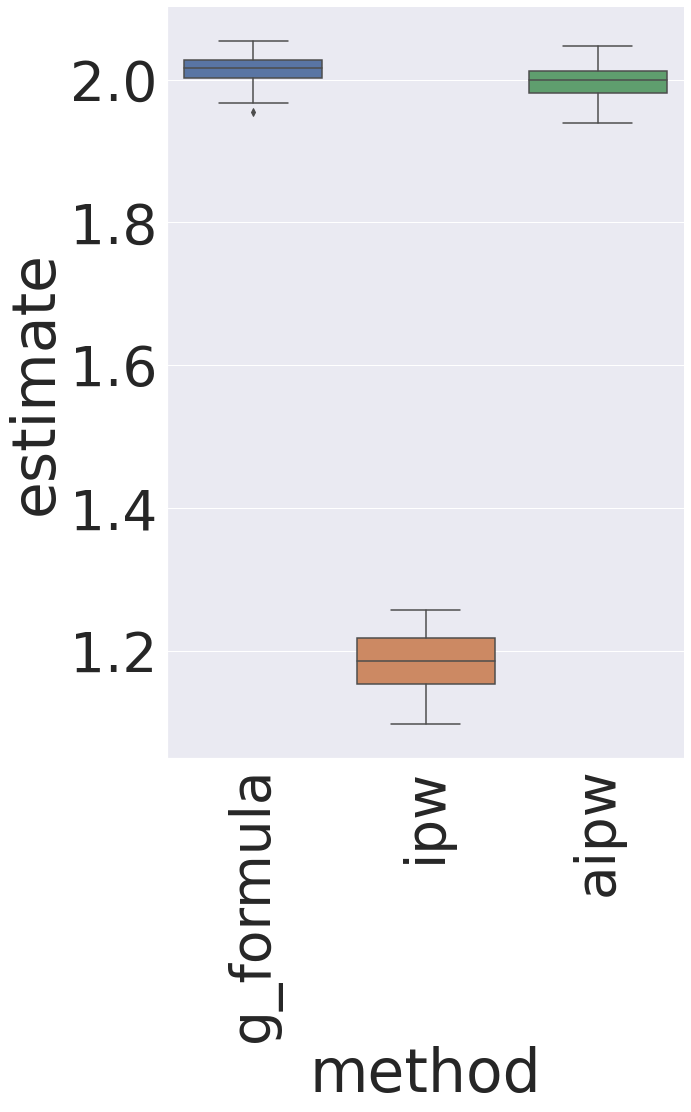

In [22]:
g = sns.catplot(x="method", y="estimate", data=my_simul_df, kind="box", **DIST_CAT_PLOT_PARAMS_D);
g.set_xticklabels(rotation=90)

3) We propose a slight different simulation, where the generative model is close to the one from Lunceford, except that it contains an interaction term or a squared term rather than a fully linear model in the covariate. The function to generate the data is modified in syntheticsimulations. You can use the option `miss_propensity=True` and/or `, miss_outcome=True`  to generate such situations.

Simulate the 4 patterns: 1) outcome and propensity score well specified, 2) outcome well specified but propensity score mispecified, 3) outcome misspecified and propensity score well specified, 4) both models are mispecified. 
Run the estimators, AIPW, IPW and G-estimator on each case. Repeat the process 100 times and represent the results with boxplots. Comment.

In [23]:
miss_estimate_l = []
COVARIATE_VARIABLE_MISS_D = {"outcome": ["X1", "X2", "X3"], "treatment": ["X1", "X2", "X3"]}
for i in tqdm(range(20)):
    #     Generate the data
    sim_nmp_nmo = generate_lunceford(n=1000, miss_propensity=False, miss_outcome=False)
    sim_nmp_mo = generate_lunceford(n=1000, miss_propensity=False, miss_outcome=True)
    sim_mp_nmo = generate_lunceford(n=1000, miss_propensity=True, miss_outcome=False)
    sim_mp_mo = generate_lunceford(n=1000, miss_propensity=True, miss_outcome=True)
    
    #         Compute ATE
    tmp_ate_nmp_nmo = list(estimate_multiple_models(sim_nmp_nmo, COVARIATE_VARIABLE_MISS_D))
    tmp_ate_nmp_mo = list(estimate_multiple_models(sim_nmp_mo, COVARIATE_VARIABLE_MISS_D))
    tmp_ate_mp_nmo = list(estimate_multiple_models(sim_mp_nmo, COVARIATE_VARIABLE_MISS_D))
    tmp_ate_mp_mo = list(estimate_multiple_models(sim_mp_mo, COVARIATE_VARIABLE_MISS_D))
    
    miss_estimate_l = miss_estimate_l + tmp_ate_nmp_nmo + tmp_ate_nmp_mo + tmp_ate_mp_nmo + tmp_ate_mp_mo
    
miss_my_sim = pd.DataFrame({"estimate": miss_estimate_l, 
                            "method": np.tile(["g_formula", "ipw", "aipw"], 4*20),
                            "miss_pattern": np.tile(["models ok"]*3 + ["miss_outcome"]*3 + ["miss_propensity"]*3 + ["miss_propensity_and_outcome"]*3, 20)})
                         

100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


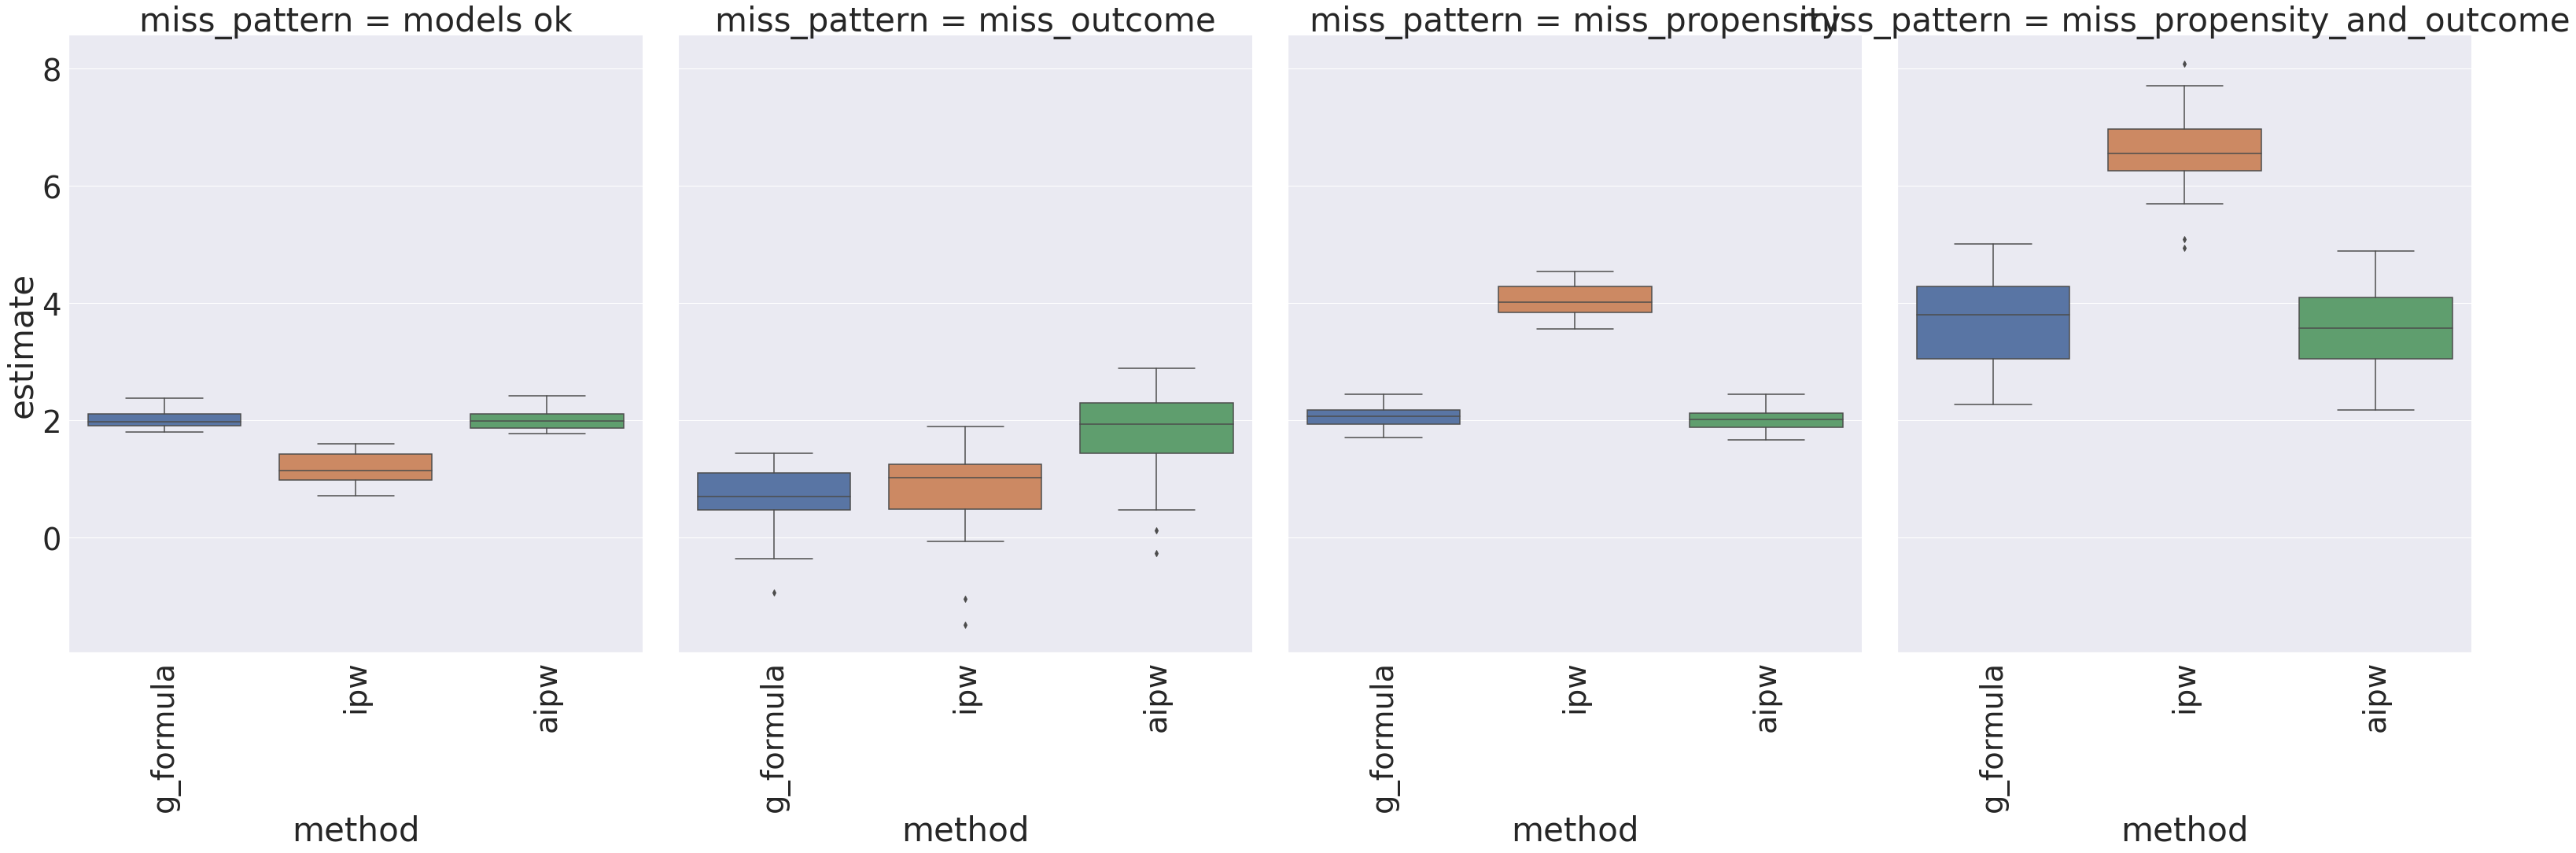

In [24]:
sns.set(font_scale=3.5)
g = sns.catplot(x="method", y="estimate", col="miss_pattern", data=miss_my_sim, kind="box", **DIST_CAT_PLOT_PARAMS_D);
g.set_xticklabels(rotation=90)

This is why double robustness is an interesting property, as you can afford to be wrong on one model.
Then, another approach to avoid assumptions is to use flexible model such as Random Forest(non parametric). 

# AIPW with random forest and cross-fitting

Then, another approach to avoid assumptions is to use flexible model, such as random forest.

To implement such an approach, you can play with the `estimate_multiple_models`'s parameters:
- `n_fold` > 1 (cross-fitting), 0 OR 1 (ordinary fitting)
- `is_parametric_outcome` (False --> RandomForest)
- `is_parametric_treatment`(False --> RandomForest)

The results are illustrated on simulations with non-linear relationship as given in the function simulation wager.

In [25]:
cross_estimate_l = []
fold_row_l = []
COVARIATE_VARIABLE_NP_CROSS_D = {"outcome": ["X1", "X2", "X3"], 
                                 "treatment": ["X1", "X2", "X3"]
                                }
n_data_per_sim = 1000
n_sim_multi_fold_np = 100

fold_l = [1, 2, 5]
fold_name_d = {**{i:"{}".format(i) for i in range(2, n_data_per_sim + 1)}, 0:"no_cross_fitting", 1:"no_cross_fitting"}


for tmp_n_fold in tqdm(fold_l):
    for i in range(n_sim_multi_fold_np):
        # Generate the data
        sim_wager_nie = generate_wager_nie(n=n_data_per_sim)

        # Compute ATE
        tmp_ate = list(estimate_multiple_models(sim_wager_nie, 
                                                 COVARIATE_VARIABLE_NP_CROSS_D, 
                                                 n_fold=tmp_n_fold,
                                                 is_parametric_outcome=False,
                                                 is_parametric_treatment=False,
                                                 clip_probabilities=True))

        cross_estimate_l = cross_estimate_l + tmp_ate
    fold_row_l = fold_row_l + (3 * n_sim_multi_fold_np) * [fold_name_d[tmp_n_fold]]

cross_my_sim = pd.DataFrame({"estimate": cross_estimate_l, 
                            "method": np.tile(["g_formula", "ipw", "aipw"], len(fold_l) * n_sim_multi_fold_np),
                            "n_fold": fold_row_l})


100%|██████████| 3/3 [10:04<00:00, 201.37s/it]


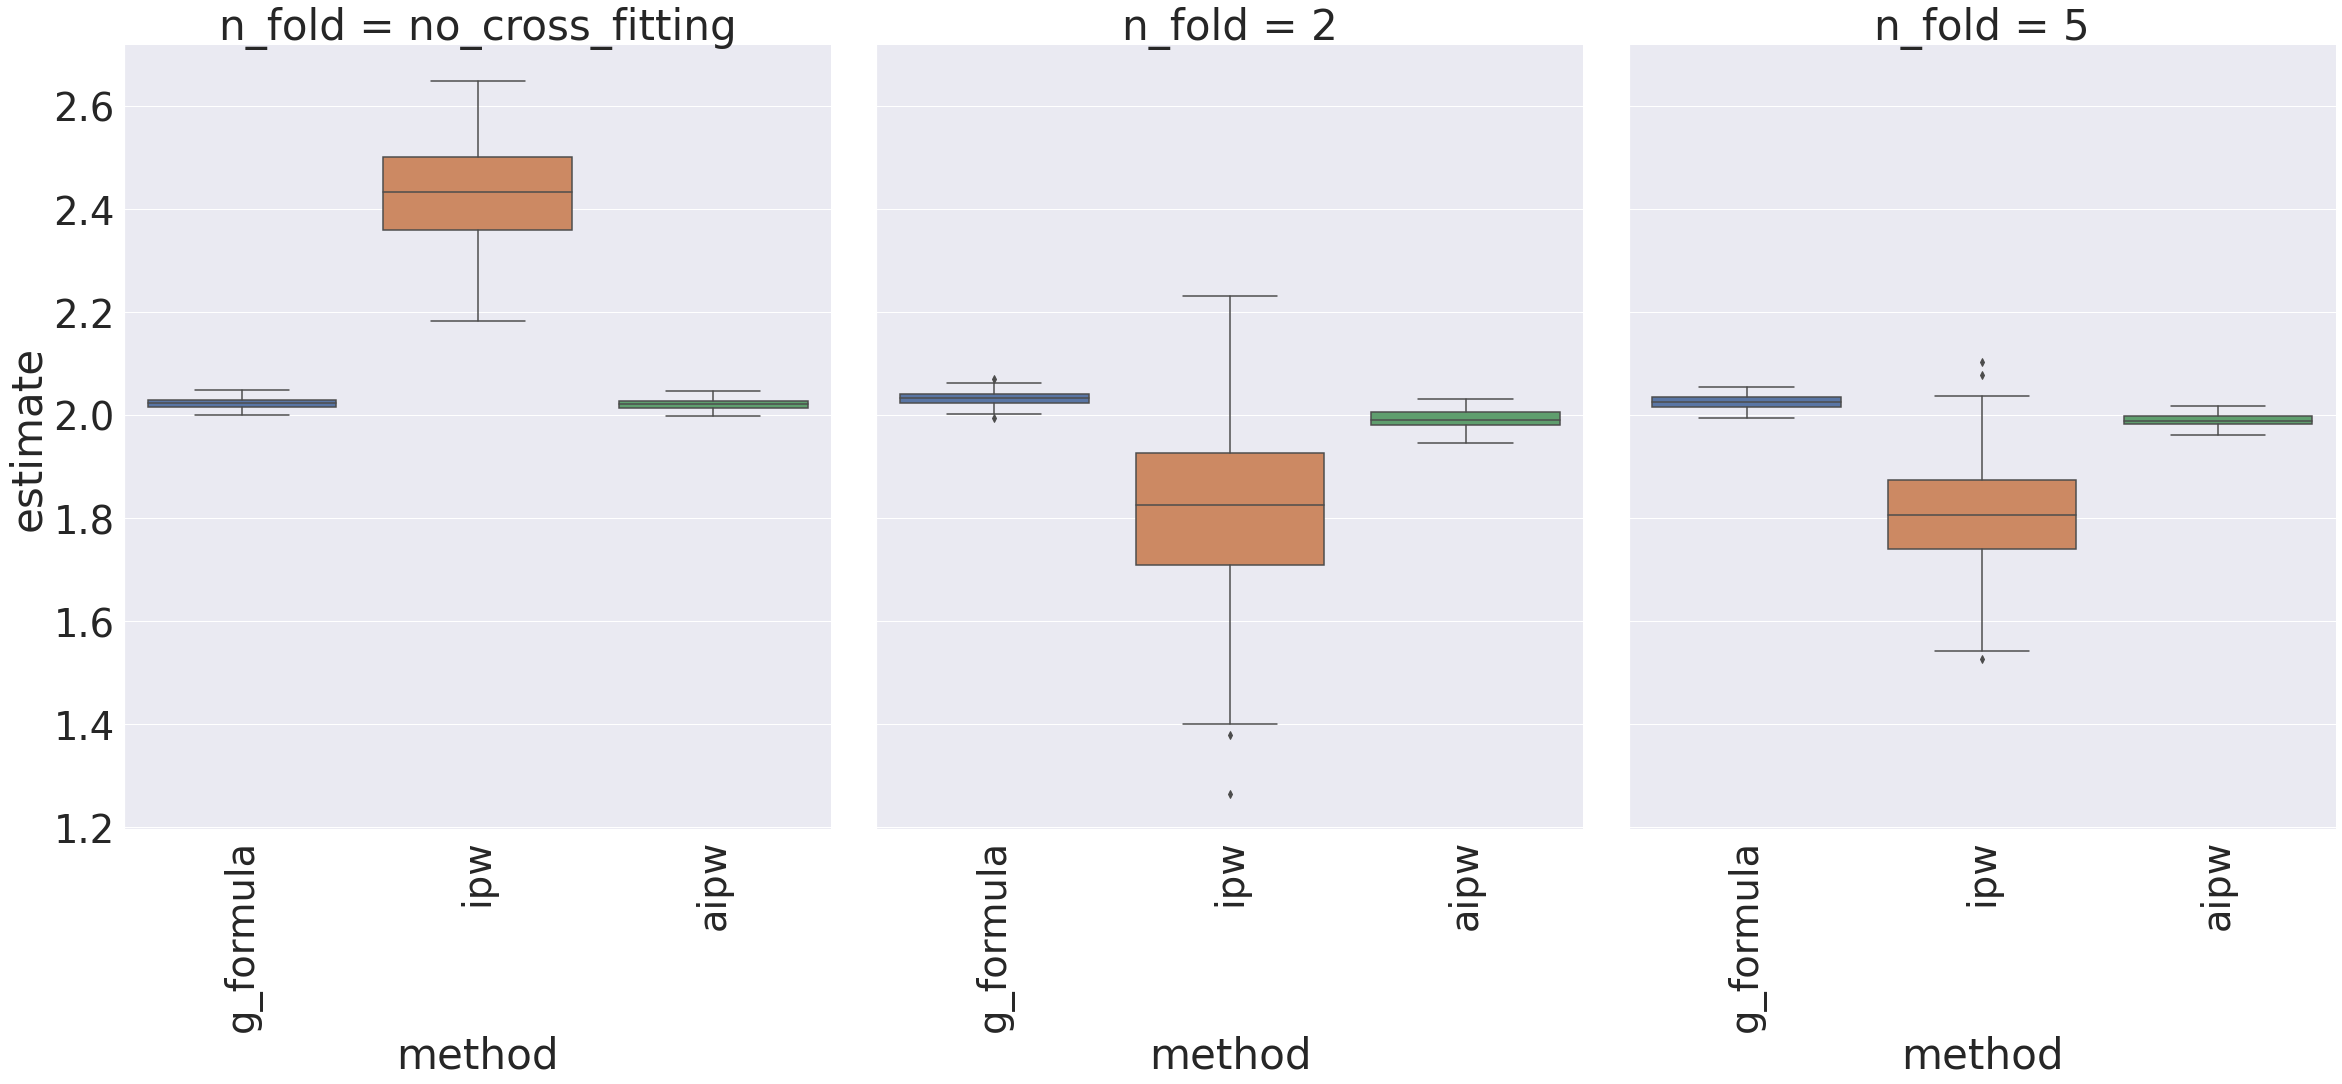

In [26]:
sns.set(font_scale=3.5)
g = sns.catplot(x="method", y="estimate", col="n_fold", data=cross_my_sim, kind="box", **DIST_CAT_PLOT_PARAMS_D);
g.set_xticklabels(rotation=90)

4) You can add on these simulations, all the other estimators, parametric AIPW, parametric and non parametric IPW and g-estimators and increases the sample size.  